# Surface Fitting

This example fits a surface to some scattered data and plots the result.

To begin, generate some scattered $(x, y)$ data, of a modest size for this example: 100 pseudorandom uniformly-distributed values on (0,1] using the Wichmann&ndash;Hill I generator.

NAG random number generators pass around their state using a communication structure which is constructed by an initialization function. To create a repeatable sequence we use `rand.init_repeat`, for which the required generator is selected using `genid = 2`:

In [1]:
from naginterfaces.library import rand
statecomm = rand.init_repeat(genid=2, seed=[32958])

Generate the scattered data using this initialized RNG state

In [2]:
n = 100
x = rand.dist_uniform01(n, statecomm)
y = rand.dist_uniform01(n, statecomm)

Ensure that the bounding box for the data includes the corners $(0, 0)$ and $(1, 1)$

In [3]:
x[0], y[0] = 0., 0.
x[-1], y[-1] = 1., 1.

Here are the function values to fit, which are from the Franke function&mdash;a popular function for testing surface-fitting methods

In [4]:
import numpy as np
f = (
    0.75*np.exp(
        -(
            (9.*x-2.)**2 +
            (9.*y-2.)**2
        )/4.
    ) +
    0.75*np.exp(
        -(9.*x+1.)**2/49. -
        (9.*y+1.)/10.
    ) +
    0.5*np.exp(
        -(
            (9.*x-7.)**2 +
            (9.*y-3.)**2
        )/4.
    ) -
    0.2*np.exp(
        -(9.*x-4.)**2 -
        (9.*y-7.)**2
    )
)

The NAG Library supplies a very configurable function (based on the TSFIT package of Davydov and Zeilfelder) for fitting a smooth ($C^1$ or $C^2$) surface to scattered data: [`fit.dim2_spline_ts_sctr`](https://www.nag.com/numeric/py/nagdoc_latest/naginterfaces.library.fit.html#naginterfaces.library.fit.dim2_spline_ts_sctr).

We need to choose a granularity for the triangulation that the function will use

In [5]:
nxcels = 6
nycels = 6

and also filtering thresholds for that triangulation

In [6]:
lsminp = 3
lsmaxp = 100

The fitting function needs its communication state to be initialized using the `fit` Chapter's initialization and option-setting function

In [7]:
from naginterfaces.library import fit
comm = {}
fit.opt_set('Initialize = dim2_spline_ts_sctr', comm)

Further algorithmic options can also be configured using the option-setting function, if the documented defaults are not desired; we would like to use $C^2$ global smoothing and for the local approximations on the triangulation to use averaged radial basis functions

In [8]:
for fit_opt in [
    'Global Smoothing Level = 2',
    'Averaged Spline = Yes',
    'Local Method = RBF',
]:
    fit.opt_set(fit_opt, comm)

Now compute the spline coefficients, which are entered into the communication structure for subsequent use by the evaluation functions for the fitter

In [9]:
fit.dim2_spline_ts_sctr(
    x, y, f, lsminp, lsmaxp, nxcels, nycels, comm,
)

For plotting the spline we use the associated mesh evaluator, which is `fit.dim2_spline_ts_evalm`. For the evaluation this requires a vector of $x$ coordinates and a vector of $y$ coordinates

In [10]:
x_m = np.linspace(0, 1, 101)
y_m = np.linspace(0, 1, 101)

The values of the spline on the grid defined by these vectors is then

In [11]:
z_m = fit.dim2_spline_ts_evalm(x_m, y_m, comm)

For compatibility with surface plotting in `matplotlib` we need to convert the mesh vectors into a mesh grid

In [12]:
X, Y = np.meshgrid(x_m, y_m, indexing='ij')

Now plot the spline surface (in wireframe here) with a projection of the contours

In [13]:
# Jupyter magic for displaying figures inline:
%matplotlib inline

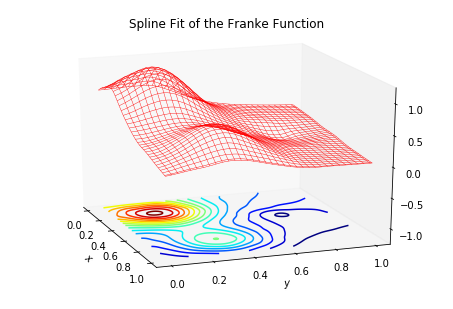

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = Axes3D(fig)
ax.grid(False)
ax.plot_wireframe(X, Y, z_m, color='red', linewidths=0.4)
ax.contour(X, Y, z_m, 15, offset=-1.2, cmap=cm.jet)
ax.set_title('Spline Fit of the Franke Function')
ax.set_xlabel(r'$\mathit{x}$')
ax.set_ylabel(r'$\mathit{y}$')
ax.set_zlim3d(-1.2, 1.2)
ax.azim = -20
ax.elev = 20
plt.show()